
We want to solve the ODE $dF/dx=xF$ with $F(0)=1$ and generate data use Euler's method on the interval $[0,1]$. We will then use the data points $x,F(x))$ to fit $\hat{y}(x)$ via least square regression. After this, we will compute the total work (or area of $\hat{y}(x))$ by employing two different trapezoid rules.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Union

##### Explicit Euler Method (h=0.05, 21 data points)

Here we implement a custom Euler solve using the formula (from textbook) $S(t_{j+1}) = S(t_{j}) + h*f(t_{j}, S(t_{j})).$ In this case, we only need to put in our desired steps to get $x=1$. In this function, $y(x) = F(x)$ and $f(x,y) = x\cdot F(x)$.

In [34]:
ArrayNP = Union[float, np.ndarray]

def explicit_euler(f:Callable, y_0:ArrayNP, step_x:float, start:float, n_steps:int):
    """
    Approximates an ODE based on previous points using Euler's method.

    :param f: Function to solve
    :param y_0: Initial state of the function F
    :param step_x: Space between each data point
    :param start: Where to start on grid
    :param n_steps: Amount of data points
    :return: Approximate solution of ODE and x values
    """
    x_vals = np.arange(start, ((n_steps * step_x)+step_x)+start, step_x)  # Compute end instead of asking user
    y = np.zeros(len(x_vals))

    y[0] = y_0

    for j in range(len(x_vals)-1):
        x_j = x_vals[j]
        y_j = y[j]

        y[j+1] = y_j + step_x * f(x_j, y_j)

    return y, x_vals

In [30]:
euler_sols, _ = explicit_euler(lambda x, y: x*y, 1, 0.05, 0, 20)  # Algorithm uses python index

print(_)
print()
print(euler_sols)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]

[1.         1.         1.0025     1.0075125  1.01506884 1.02521953
 1.03803478 1.0536053  1.07204339 1.09348426 1.11808765 1.14603985
 1.17755594 1.21288262 1.2523013  1.29613185 1.34473679 1.39852627
 1.45796363 1.523572   1.59594167]


**Interpretation:** The array euler_sols, is the Euler approximation of the force F(x) in Newtons ($N$) along 21 ($h=0.05$) spaced points in the interval $[0,1]$ with the initial condition $F(0)=1$. The data looks accurate.

##### Create a custom Least Squares Regression function to fit $\hat{y}(x)$ with previously generated data points $(x,F(x))$.

We will need to use the log transform to compute $\hat{y}(x)$. If we let $f(x) = \ln(y(x))$, then $ln{y}=ln{\alpha}+\beta \cdot x$. If we let $m=\beta$ be the slope and $n=ln{\alpha}$ be the y-intercept, then we can compute both using the linear least squares method since $f(x)\approx mx+n$.

In [35]:

def least_squares(x_vals:np.ndarray, y_vals:np.ndarray):
    """
    Approximates an ODE given data points using exponential LSR model.

    :param x_vals: Numpy array of x-values
    :param y_vals: Numpy array of y-values
    :return: Alpha and beta values for exponential LSR model
    """
    if np.any(y_vals <= 0):
        raise ValueError("All y values must be positive for log transform.")

    f = np.log(y_vals)

    #  We need to find alpha and beta

    data_points = x_vals.size
    sum_x = np.sum(x_vals)
    sum_f = np.sum(f)
    sum_xf = np.sum(x_vals * f)
    sum_x2 = np.sum(x_vals**2)

    denom = data_points * sum_x2 - sum_x**2
    if denom == 0:
        raise ValueError("Denominator is zero. Cannot compute alpha and beta.")

    slope = (data_points * sum_xf - sum_x * sum_f) / denom
    y_intercept = (sum_f - slope * sum_x) / data_points

    return float(np.exp(y_intercept)), float(slope)  # Alpha and beta


##### Now, compute $\alpha$ and $\beta$ using $(x,F(x)$ data points so we can fit to $\hat{y}(x)$.

For plotting, create new points for $x$ values so that the curve will be smooth.

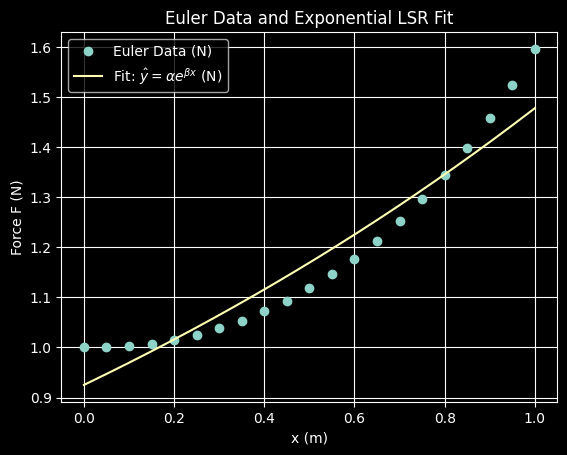

Alpha: 0.9252611590541637
Beta: 0.46814394522233044


In [27]:
alpha, beta = least_squares(_, euler_sols)

x_smooth_values = np.linspace(0.0, 1.0, 400)
F_fit_smooth_values = alpha * np.exp(beta * x_smooth_values)

plt.figure()
plt.plot(_, euler_sols, marker="o", linestyle="None", label="Euler Data (N)")
plt.plot(x_smooth_values, F_fit_smooth_values, label=r"Fit: $\hat y=\alpha e^{\beta x}$ (N)")
plt.xlabel("x (m)")
plt.ylabel("Force F (N)")
plt.title("Euler Data and Exponential LSR Fit")
plt.legend()
plt.grid(True)
plt.show()

print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

**Interpretation:** The fitted model $\hat{y}(x)$ fits the Euler data points relatively well. In this case, the model is approximating force in Newtons. $\alpha$ would be in Newtons and $\beta$ would have units of $\text{m}^{-1}$ since $\beta$ is the slope of $\ln{y}=\ln{\alpha}+\beta \cdot x$.

##### Compute the total work done by the force F(x) over the interval [0,1] using the trapezoid rule in two ways.

First, we will want to use the trapezoid rule on the Euler data points. Second, we will do the same, but for the fitted model $\hat{y}(x)$. After, we will compare the two results.

In [33]:

def trapezoid_rule(x_vals:np.ndarray, y_vals:np.ndarray):
    """
    Calculates the work (using numerical integration) done by a force F(x) over an interval [a,b] using the trapezoid rule.

    :param x_vals: Numpy array of x-values
    :param y_vals: Numpy array of y-values
    :return: Work done by force F(x) over interval [a,b]
    """
    if x_vals.size != y_vals.size:
        raise ValueError("x values and y values must have the same size.")

    if np.any(np.diff(x_vals) <= 0):
        raise ValueError("x values must be increasing.")

    d_x = np.diff(x_vals)  # Determine the nth difference, another way to calculate h
    return float(np.sum(d_x * 0.5 * (y_vals[1:]+y_vals[:-1])))  # Trapezoid rule, indexing f(x_{i+1}) and f(x_{i}) at each step

work_euler_data = trapezoid_rule(_, euler_sols)

F_fit_grid_values = alpha * np.exp(beta * _)
work_fit_data = trapezoid_rule(_, F_fit_grid_values)

abs_diff = np.abs(work_fit_data - work_euler_data)

print(f"Work of Euler data: {work_euler_data:.10f} Nm")
print(f"Work of fit data: {work_fit_data:.10f} Nm")
print(f"Absolute difference: {abs_diff:.10f} Nm")


Work of Euler data: 1.1766618670 Nm
Work of fit data: 1.1800459486 Nm
Absolute difference: 0.0033840816 Nm


**Interpretation:** Both the Euler data and the fitted model yield similar results for the total amount of work done by the force F(x) over the interval [0,1]. The absolute difference measures how closely the exponential LSR fit approximates the discrete Euler data on the same grid.

##### Showcasing help() function calling.

In [36]:
help(explicit_euler)
help(least_squares)
help(trapezoid_rule)

Help on function explicit_euler in module __main__:

explicit_euler(
    f: Callable,
    y_0: Union[float, numpy.ndarray],
    step_x: float,
    start: float,
    n_steps: int
)
    Approximates an ODE based on previous points using Euler's method.

    :param f: Function to solve
    :param y_0: Initial state of the function F
    :param step_x: Space between each data point
    :param start: Where to start on grid
    :param n_steps: Amount of data points
    :return: Approximate solution of ODE and x values

Help on function least_squares in module __main__:

least_squares(x_vals: numpy.ndarray, y_vals: numpy.ndarray)
    Approximates an ODE given data points using exponential LSR model.

    :param x_vals: Numpy array of x-values
    :param y_vals: Numpy array of y-values
    :return: Alpha and beta values for exponential LSR model

Help on function trapezoid_rule in module __main__:

trapezoid_rule(x_vals: numpy.ndarray, y_vals: numpy.ndarray)
    Calculates the work (using nume